# Perceptron

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Perceptron Learning Algorithm

**Predict the output:**
$$z = w^T x + b$$
$$\hat{y} = \sigma(z)$$

**Update the weights and bias (Fit):**
$$\Delta{w_{j}} = \eta (y - \hat{y}) x_{j}$$
$$\Delta{b} = \eta (y - \hat{y})$$

$$w_{j} = w_{j} + \Delta{w_{j}}$$
$$b = b + \Delta{b}$$


<br>

Where:

$\Delta{w_{j}}$ is the change in weight, $\Delta{b}$ is the change in bias, $\eta$ is the learning rate.

In [3]:
class Perceptron:
    """
    Perceptron classifier.

    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    epochs : int
        Number of passes over the training dataset
    seed : int, optional (default=42)
        Random number generator seed for random weight initialization
    """

    def __init__(self, eta: float, epochs: int, seed: int = 42) -> None:
        """
        Initialize the perceptron.

        Parameters
        ----------
        eta : float
            Learning rate (between 0.0 and 1.0)
        epochs : int
            Number of passes over the training dataset
        seed : int, optional (default=42)
            Random number generator seed for random weight initialization
        """
        assert 0 <= eta <= 1, "eta must be between 0 and 1"
        assert epochs >= 1, "epochs must be greater than 0"
        assert seed >= 0, "seed must be greater than or equal to 0"
        self.eta = eta
        self.epochs = epochs
        self.seed = seed

    def __repr__(self) -> str:
        """
        Return a string representation of the perceptron.

        Returns
        -------
        str
            String representation of the perceptron
        """
        return (
            f"{self.__class__.__name__}(eta={self.eta}, "
            f"epochs={self.epochs}, seed={self.seed})"
        )

    def fit(self, X: np.ndarray, y: np.ndarray) -> "Perceptron":
        """
        Fit the training data.

        Parameters
        ----------
        X : np.ndarray, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : np.ndarray, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object
        """
        rng = np.random.default_rng(self.seed)
        n_features: int = X.shape[1]
        self.w_: np.ndarray = rng.normal(loc=0, scale=0.01, size=n_features)
        self.b_: np.ndarray = np.float_(0)
        self.errors_: list[int] = []

        for _ in range(self.epochs):
            errors: int = 0
            for x, target in zip(X, y):
                update: np.ndarray = self.eta * (target - self.predict(x))
                self.w_ += update * x
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Calculate the linear activation.

        Parameters
        ----------
        X : np.ndarray, shape = [n_samples, n_features]
            Input vectors.

        Returns
        -------
        z : np.ndarray, shape = [n_samples]
            Linear activation
        """
        z: np.ndarray = X.dot(self.w_) + self.b_
        return z

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return class label after unit step.

        Parameters
        ----------
        X : np.ndarray, shape = [n_samples, n_features]
            Input vectors.

        Returns
        -------
        class_labels : np.ndarray, shape = [n_samples]
            Predicted class labels.
        """
        return np.where(self._predict(X) >= 0.0, 1, 0)

In [4]:
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)

X: np.ndarray = np.array([[1, 2, 3, 2.5, -5], [2.0, 5.0, -5.0, -2.0, 3.5]]).reshape(
    -1, 2
)
y = np.array([1, 1, 0, 1, 0])

ppn.fit(X, y)

Perceptron(eta=0.1, epochs=10, seed=2)

In [5]:
ppn.predict(X)

array([1, 1, 0, 1, 0])

In [6]:
# Raw values
ppn._predict(X), X.shape

(array([ 0.19143556,  1.24260289, -3.41990764,  4.73559009, -2.07207726]),
 (5, 2))

In [7]:
ppn.errors_

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]

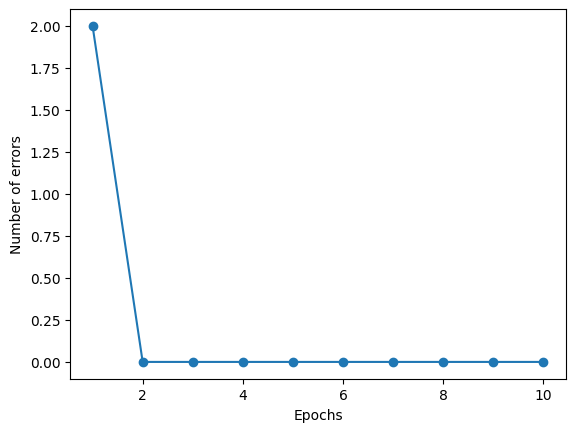

In [8]:
# Visualize the errors
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of errors")
plt.show()

In [9]:
fp: str = "./data/iris_data.csv"
df: pl.DataFrame = pl.read_csv(fp)
df = df.filter(pl.col("class").ne("None"))

df.head()

sepal_length,sepal_width,petal_length,petal_width,class
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""Iris-setosa"""
4.9,3.0,1.4,0.2,"""Iris-setosa"""
4.7,3.2,1.3,0.2,"""Iris-setosa"""
4.6,3.1,1.5,0.2,"""Iris-setosa"""
5.0,3.6,1.4,0.2,"""Iris-setosa"""


In [10]:
df.select("class").to_series().value_counts().to_pandas()

,class,count
0,Iris-versicolor,50
1,Iris-virginica,50
2,Iris-setosa,50


In [11]:
X: np.ndarray = df.select(
    # ["sepal_length", "sepal_width", "petal_length", "petal_width"]
    ["sepal_length", "petal_length"]
).to_numpy()

y: np.ndarray = (
    df.with_columns(
        label=pl.when(pl.col("class").eq("Iris-setosa"))
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
    )
    .select("label")
    .to_numpy()
    .squeeze()
)

X.shape, y.shape

((150, 2), (150,))

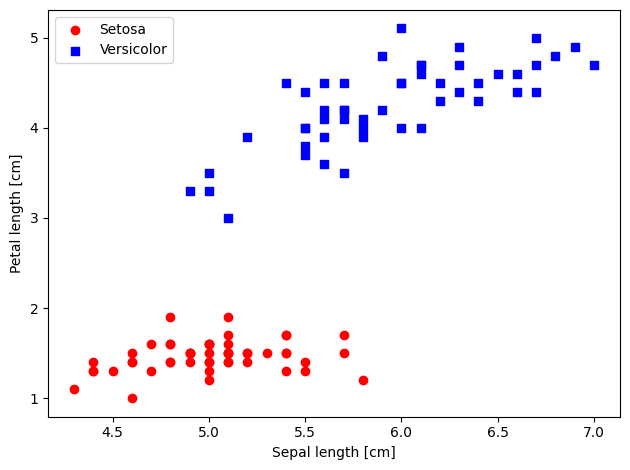

In [12]:
# plot data
plt.scatter(X[:50, 0], X[:50, 1], color="red", marker="o", label="Setosa")
plt.scatter(X[50:100, 0], X[50:100, 1], color="blue", marker="s", label="Versicolor")
plt.xlabel("Sepal length [cm]")
plt.ylabel("Petal length [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

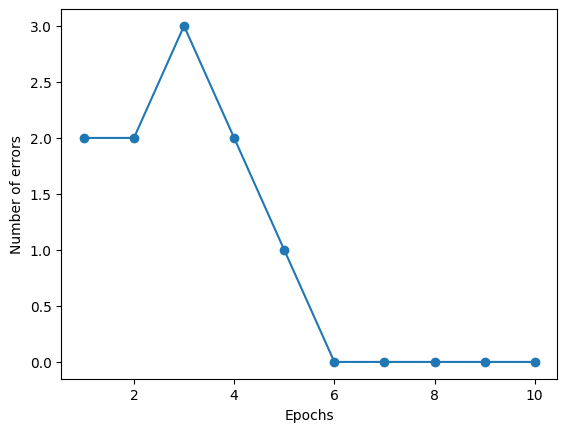

In [13]:
# Visualize the errors
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of errors")
plt.show()

In [14]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(
    X: np.ndarray, y: np.ndarray, classifier: Any, resolution: float = 0.02
) -> None:
    """
    Plot decision regions for a classifier.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Input features.
    y : np.ndarray of shape (n_samples,)
        Target labels.
    classifier : Any
        Trained classifier object with a predict method.
    resolution : float, optional, default=0.02
        Step size for the contours.

    Returns
    -------
    None
    """
    # Setup marker generator and color map
    markers: tuple[str, ...] = ("o", "s", "^", "v", "<")
    colors: tuple[str, ...] = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap: ListedColormap = ListedColormap(colors[: len(np.unique(y))])

    x1_min: float = X[:, 0].min() - 1
    x1_max: float = X[:, 0].max() + 1
    x2_min: float = X[:, 1].min() - 1
    x2_max: float = X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )

    lab: np.ndarray = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolor="black",
        )

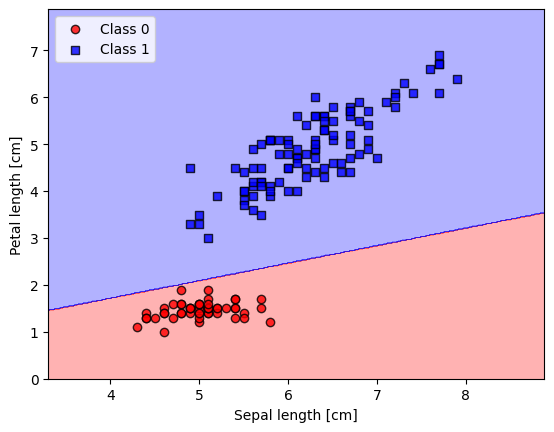

In [15]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel("Sepal length [cm]")
plt.ylabel("Petal length [cm]")
plt.legend(loc="upper left")
plt.show()

### Comment

#### Perceptron convergence

- The perceptron works well for linearly separable data but struggles with complex patterns.
- It may never converge if data is not linearly separable, requiring a maximum epoch limit.


### ADALINE (ADAptive LInear NEuron)

- ADALINE is a single-layer neural network using a linear activation function.
- It minimizes error through the `Delta Rule`, adjusting weights based on the calculated error.
- Unlike the perceptron, ADALINE uses a linear activation function and focuses on error minimization.


<img src="./images/Adaline 2024-07-13 at 1.52.34 PM.png" width="600">

[image source](https://subscription.packtpub.com/book/data/9781801819312/2/ch02lvl1sec11/adaptive-linear-neurons-and-the-convergence-of-learning)

<br>

### Minimizing loss functions with gradient descent

- Adaline's learning process involves minimizing the mean squared error (MSE) between the predicted and actual outputs. This MSE serves as the objective function to optimize during training.

$$ MSE = \frac{1}{n}\sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^2 $$
$$ L(w, b) = MSE $$

- Adaline's continuous linear activation function allows for differentiable loss function, unlike the unit step function. This enables the use of gradient descent optimization, which efficiently minimizes the loss function for accurate Iris dataset classification.

- Gradient descent finds the lowest point on a surface by taking steps opposite to the slope, guided by learning rate and gradient steepness.

<br>

<img src="./images/Gradient descent 2024-07-13 at 2.11.44 PM.png" width="600">

[image source](https://subscription.packtpub.com/book/data/9781801819312/2/ch02lvl1sec11/adaptive-linear-neurons-and-the-convergence-of-learning)


**Compute the gradient of the loss function with respect to each weight.**
$$ \frac{\delta_{L}}{\delta_{w_{j}}} = -\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})x_{j}^{(i)} $$
$$ \frac{\delta_{L}}{\delta_{b}} = -\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)}) $$

- Update in weights and bias is obtained by multiply -ve gradient with learning rate.

eq (1)
$$ \Delta{w} = -\eta * (\Delta_{w}  L(w,b)) $$
$$ \Delta{w} = -\eta * (-\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})x_{j}^{(i)}) $$  

eq (2)
$$ \Delta{b} = -\eta * (\Delta_{b}  L(w,b)) $$
$$ \Delta{b} = -\eta * (-\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})) $$


Where:

$ \Delta_{w}L(w,b) = \frac{\delta_{L}}{\delta_{w_{j}}} $

$ \Delta_{b}L(w,b) = \frac{\delta_{L}}{\delta_{w}} $


eq (3)
$$ w = w + \Delta{w} $$
$$ b = b + \Delta{b} $$



#### Training: Fit
$$z = (X^Tw + b)$$
$$\hat{y} = \sigma(z)$$

#### Update weights and bias

$$ w = w + \Delta{w} $$
$$ b = b + \Delta{b} $$

Where:

$ \sigma(z) $ is a `linear` activation function.

In [16]:
A: np.ndarray = np.array([[1, 2, 3], [4, 5, 6]]).reshape(-1, 2)
w: np.ndarray = np.random.normal(0, 0.01, (2,))

# A -> (n_samples, n_features); w -> (1, n_features)
# w @ A.T -> (1, n_features) @ (n_features, n_samples) -> (1, n_samples)
result: np.ndarray = w @ A.T  # np.dot(w, A.T)

print(f"{A.shape = }")
print(f"{w.shape = }")
print(f"{result.shape = }")

A.shape = (3, 2)
w.shape = (2,)
result.shape = (3,)


In [17]:
np.dot(w, A.T)

array([-0.02993104, -0.05901182, -0.0880926 ])

In [18]:
class AdalineGD:
    """
    Adaptive Linear Neuron Classifier.

    This class implements the Adaptive Linear Neuron (ADALINE) algorithm for binary classification.

    Attributes
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0).
    epochs : int
        Number of passes over the training dataset.
    seed : int
        Random state for reproducibility.
    w_ : np.ndarray
        Weights after fitting.
    b_ : float
        Bias unit after fitting.
    losses_ : List[float]
        Mean squared errors per epoch.

    """

    def __init__(self, eta: float, epochs: int, seed: int = 42) -> None:
        """
        Initialize AdalineGD.

        Parameters
        ----------
        eta : float
            Learning rate (between 0.0 and 1.0).
        epochs : int
            Number of passes over the training dataset.
        seed : int, optional
            Random state for reproducibility. Defaults to 42.

        Raises
        ------
        AssertionError
            If eta is not between 0 and 1, epochs is less than 1, or seed is negative.
        """
        assert 0 <= eta <= 1, "eta must be between 0 and 1"
        assert epochs >= 1, "epochs must be greater than 0"
        assert seed >= 0, "seed must be greater than or equal to 0"
        self.eta = eta
        self.epochs = epochs
        self.seed = seed

    def __repr__(self) -> str:
        """
        Return a string representation of the AdalineGD instance.

        Returns
        -------
        str
            String representation of the instance.
        """
        return (
            f"{self.__class__.__name__}(eta={self.eta}, "
            f"epochs={self.epochs}, seed={self.seed})"
        )

    def fit(self, X: np.ndarray, y: np.ndarray) -> "AdalineGD":
        """
        Fit training data.

        Parameters
        ----------
        X : np.ndarray
            Training vectors, shape: (n_samples, n_features).
        y : np.ndarray
            Target values, shape: (n_samples,).

        Returns
        -------
        AdalineGD
            Fitted estimator.
        """
        rng: np.random.Generator = np.random.default_rng(self.seed)
        n_samples: int
        n_features: int
        n_samples, n_features = X.shape
        self.w_: np.ndarray = rng.normal(loc=0, scale=0.01, size=(n_features,))
        self.b_: float = np.float_(0)
        self.losses_: list[float] = []

        for _ in range(self.epochs):
            z: np.ndarray = self._predict(X)
            output: np.ndarray = self._activation(z)
            error: np.ndarray = y - output

            dw: np.ndarray = -self.eta * ((-2 * np.dot(error, X)) / n_samples)
            db: float = -self.eta * ((-2 * np.sum(error)) / n_samples)
            self.w_ += dw
            self.b_ += db

            loss: float = np.mean(error**2)
            self.losses_.append(loss)
        return self

    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Compute net input.

        Parameters
        ----------
        X : np.ndarray
            Input data, shape: (n_samples, n_features).

        Returns
        -------
        np.ndarray
            Net input, shape: (1, n_samples).
        """
        z: np.ndarray = np.dot(self.w_, X.T) + self.b_
        return z

    def _activation(self, X: np.ndarray) -> np.ndarray:
        """
        Compute linear activation.

        Parameters
        ----------
        X : np.ndarray
            Input data.

        Returns
        -------
        np.ndarray
            Activated input (same as input for linear activation).
        """
        return X

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return class label after unit step.

        Parameters
        ----------
        X : np.ndarray
            Input data, shape: (n_samples, n_features).

        Returns
        -------
        np.ndarray
            Predicted class labels, shape: (n_samples,).
        """
        return np.where(self._activation(self._predict(X)) >= 0.5, 1, 0)

In [19]:
ada: AdalineGD = AdalineGD(eta=0.1, epochs=15, seed=1)
ada.fit(X, y)

AdalineGD(eta=0.1, epochs=15, seed=1)

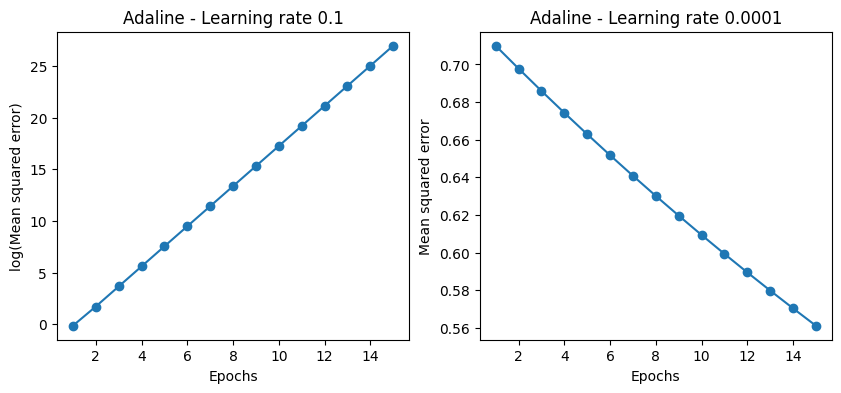

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1: AdalineGD = AdalineGD(eta=0.1, epochs=15).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(Mean squared error)")
ax[0].set_title("Adaline - Learning rate 0.1")

ada2: AdalineGD = AdalineGD(eta=0.0001, epochs=15).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker="o")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean squared error")
ax[1].set_title("Adaline - Learning rate 0.0001")


plt.show()

### Comment

- The learning rate significantly impacts gradient descent. A rate too high can overshoot the minimum, while a rate too low slows convergence.

<br>

<img src="./images/learning rate 2024-07-13 at 5.11.40 PM.png" width="700">

[image source](https://subscription.packtpub.com/book/data/9781801819312/2/ch02lvl1sec11/adaptive-linear-neurons-and-the-convergence-of-learning)

In [21]:
print(f"{A.shape = }")

# Flatten the array (1D)
A_ravel: np.ndarray = A.ravel()
print(f"{A_ravel.shape = }")

A.shape = (3, 2)
A_ravel.shape = (6,)


### Mini-batch Gradient Descent

- Mini-batch gradient descent is a middle ground between full batch and stochastic gradient descent.
- It processes data in smaller groups (mini-batches) rather than the entire dataset or individual data points.
- This method offers faster convergence than full batch while maintaining computational efficiency through vectorization, making it a popular choice in deep learning.

In [22]:
class AdalineSGD:
    """
    AdalineSGD classifier.

    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    epochs : int
        Passes over the training dataset.
    seed : int, default=42
        Random number generator seed for random weight initialization.
    shuffle : bool, default=True
        Shuffles training data every epoch if True to prevent cycles.

    Attributes
    ----------
    w_ : np.ndarray
        Weights after fitting.
    b_ : float
        Bias unit after fitting.
    losses_ : list of float
        Mean squared error loss function values in each epoch.
    """

    def __init__(
        self, eta: float, epochs: int, seed: int = 42, shuffle: bool = True
    ) -> None:
        """
        Initialize the AdalineSGD classifier.

        Parameters
        ----------
        eta : float
            Learning rate (between 0.0 and 1.0)
        epochs : int
            Passes over the training dataset.
        seed : int, default=42
            Random number generator seed for random weight initialization.
        shuffle : bool, default=True
            Shuffles training data every epoch if True to prevent cycles.
        """
        assert 0 <= eta <= 1, "eta must be between 0 and 1"
        assert epochs >= 1, "epochs must be greater than 0"
        assert seed >= 0, "seed must be greater than or equal to 0"
        self.eta = eta
        self.epochs = epochs
        self.seed = seed
        self.shuffle = shuffle
        self.w_initialized = False

    def __repr__(self) -> str:
        """
        Return a string representation of the AdalineSGD classifier.

        Returns
        -------
        str
            String representation of the classifier.
        """
        return (
            f"{self.__class__.__name__}(eta={self.eta}, "
            f"epochs={self.epochs}, seed={self.seed})"
        )

    def fit(self, X: np.ndarray, y: np.ndarray) -> "AdalineSGD":
        """
        Fit training data.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : np.ndarray, shape=[n_samples]
            Target values.

        Returns
        -------
        self : AdalineSGD
            Fitted estimator.
        """
        self._initialize_weights(X)
        self.losses_: list[float] = []

        for _ in range(self.epochs):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses: list[float] = []

            for xi, target in zip(X, y):
                # For a single sample
                losses.append(self._update_weights_n_calculate_loss(xi, target))
            avg_loss: float = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X: np.ndarray, y: np.ndarray) -> "AdalineSGD":
        """
        Fit training data without reinitializing the weights.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : np.ndarray, shape=[n_samples]
            Target values.

        Returns
        -------
        self : AdalineSGD
            Fitted estimator.
        """
        if not self.w_initialized:
            self._initialize_weights(X)
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights_n_calculate_loss(xi, target)
        else:
            self._update_weights_n_calculate_loss(X, y)
        return self

    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Calculate net input.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Input vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        z : np.ndarray, shape=[n_samples]
            Net input.
        """
        z: np.ndarray = np.dot(self.w_, X.T) + self.b_
        return z

    def _activation(self, X: np.ndarray) -> np.ndarray:
        """
        Compute linear activation.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples]
            Net input.

        Returns
        -------
        X : np.ndarray, shape=[n_samples]
            Linear activation.
        """
        return X

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return class label after unit step.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Input vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        y_pred : np.ndarray, shape=[n_samples]
            Predicted class labels.
        """
        return np.where(self._activation(self._predict(X)) >= 0.5, 1, 0)

    def _initialize_weights(self, X: np.ndarray) -> None:
        """
        Initialize weights to small random numbers.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        """
        self.rng: np.random.Generator = np.random.default_rng(self.seed)
        n_features: int = X.shape[1]
        self.w_: np.ndarray = self.rng.normal(loc=0, scale=0.01, size=(n_features,))
        self.b_: float = np.float_(0.0)
        self.w_initialized: bool = True

    def _shuffle(self, X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Shuffle training data.

        Parameters
        ----------
        X : np.ndarray, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : np.ndarray, shape=[n_samples]
            Target values.

        Returns
        -------
        X_shuffled : np.ndarray, shape=[n_samples, n_features]
            Shuffled training vectors.
        y_shuffled : np.ndarray, shape=[n_samples]
            Shuffled target values.
        """
        r: np.ndarray = self.rng.permutation(X.shape[0])
        return X[r], y[r]

    def _update_weights_n_calculate_loss(
        self, xi: np.ndarray, target: np.ndarray
    ) -> float:
        """
        Update the weights and calculate the loss for a single example.

        Parameters
        ----------
        xi : np.ndarray, shape=[n_features]
            Training vector, where n_features is the number of features.
        target : np.ndarray, shape=[1]
            Target value.

        Returns
        -------
        loss : float
            Mean squared error loss.
        """
        output: np.ndarray = self._activation(self._predict(xi))
        error: np.ndarray = target - output

        dw: np.ndarray = -self.eta * -2.0 * error * xi
        db: float = -self.eta * -2.0 * error
        self.w_ += dw
        self.b_ += db

        loss: float = error**2
        return loss

In [23]:
X_std: np.ndarray = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
X_std.shape

(150, 2)

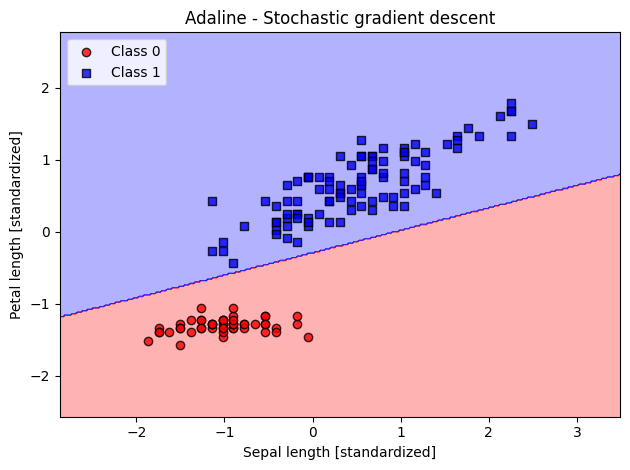

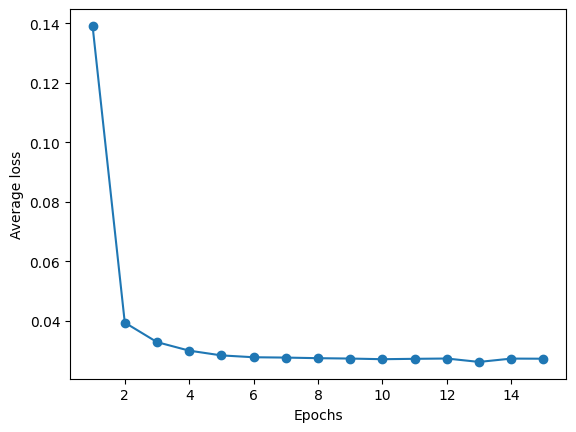

In [24]:
ada_sgd: AdalineSGD = AdalineSGD(eta=0.01, epochs=15, seed=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title("Adaline - Stochastic gradient descent")
plt.xlabel("Sepal length [standardized]")
plt.ylabel("Petal length [standardized]")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average loss")

plt.show()

In [25]:
ada_sgd.predict(X_std)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
ada_sgd.losses_

[0.13912495410957101,
 0.03933805659869092,
 0.03277986543693456,
 0.029904817471044124,
 0.028307577828163843,
 0.027685993537617103,
 0.02757180187361387,
 0.027370117922935908,
 0.02724579612745349,
 0.027027850906664846,
 0.027156466962237027,
 0.027256447292994004,
 0.026113355015338114,
 0.027231439144153533,
 0.02719360863608521]

<hr>

### Comment

- `Perceptron`: Updates weights based on the binary error (correct or incorrect classification).
- `Adaline`: Updates weights based on the continuous error (difference between the desired output and the actual output), making it more efficient.
- `Perceptron` is simpler but limited to linearly separable data.
- `Adaline` is more flexible and can handle a wider range of problems, but its convergence is not guaranteed.
`Adaline` is often considered an improvement over the `Perceptron` due to its continuous error calculation, which allows for more efficient weight updates